In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import subprocess
from itertools import product
from pathlib import Path
from pprint import pprint

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from chainconsumer import Chain, ChainConsumer, PlotConfig, Truth
from corner import corner
from KDEpy import *
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr

from fm4ar.datasets.vasist_2023.prior import NAMES, LABELS, THETA_0, LOWER, UPPER
from fm4ar.nested_sampling.posteriors import load_posterior

In [4]:
# Define colorblind-friendly colors
COLORS = [
    "#5790fc",  # blue
    "#fddcb1",  # light orange
    "#f89c20",  # dark organge
    "#f1929b",  # light red
    "#e42536",  # dark red
]

In [5]:
def normalize_weights(weights: np.ndarray) -> np.ndarray:
    """
    Normalize weights such that sum(weights) == len(weights).
    """

    return weights * len(weights) / np.sum(weights)


def get_effective_sample_size(weights: np.ndarray) -> float:
    """
    Compute the effective sample size.
    """

    weights = normalize_weights(weights)
    return np.sum(weights) ** 2 / np.sum(weights ** 2)


def get_subsample_idx(a: np.ndarray, target_size: int = 50_000) -> int:
    """
    Find the smallest index `n` such that 
    `get_effective_sample_size(a[:n]) >= target_size`.
    """

    low, high = 0, len(a)
    n = high

    while low <= high:
        mid = (low + high) // 2
        if get_effective_sample_size(a[:mid]) >= target_size:
            n = mid
            high = mid - 1
        else:
            low = mid + 1

    return n


def array_to_df(a: np.ndarray) -> pd.DataFrame:
    """
    Convert an array of samples into a dataframe (because that's 
    what chainconsumer needs).
    """

    return pd.DataFrame({label: a[:, i] for i, label in enumerate(LABELS)})

# Load all results

In [6]:
results = {}
target_size = 50_000

In [7]:
# !scp mpicluster:/home/tgebhard/projects/fm4ar/experiments/aaai-workshop/fmpe/importance_sampling/importance_sampling_results_minimized.hdf ./results/fmpe/ 2> /dev/null
# !scp mpicluster:/home/tgebhard/projects/fm4ar/experiments/aaai-workshop/npe/importance_sampling/importance_sampling_results_minimized.hdf ./results/npe/ 2> /dev/null
# !scp mpicluster:/home/tgebhard/projects/fm4ar/experiments/aaai-workshop/unconditional-flow/importance_sampling/importance_sampling_results_minimized.hdf ./results/unconditional-flow/ 2> /dev/null

In [8]:
# Load results from unconditional flow as the reference
file_path = Path("results/unconditional-flow") / "importance_sampling_results_minimized.hdf"
with h5py.File(file_path, "r") as f:
    samples = np.array(f["theta"])
    weights = np.array(f["weights"])

# Drop the maximum weight (crazy outlier)
idx = np.argmax(weights)
mask = np.ones_like(weights).astype(bool)
mask[idx] = False
samples = samples[mask]
weights = weights[mask]
weights = normalize_weights(weights)

# Get effective sample size
print(f"Sampling efficiency:   {100 * get_effective_sample_size(weights) / len(weights):,.2f}%")
print(f"Effective sample size: {get_effective_sample_size(weights):,.0f}")

# Store in dict
results["reference"] = dict(
    label="Reference",
    samples=samples,
    weights=weights,
)

Sampling efficiency:   6.22%
Effective sample size: 616,816


In [9]:
# !scp mpicluster:/home/tgebhard/projects/fm4ar/scripts/nested_sampling/results/nautilus/15_high-res/config.yaml ./results/nautilus/ 2> /dev/null
# !scp mpicluster:/home/tgebhard/projects/fm4ar/scripts/nested_sampling/results/nautilus/15_high-res/posterior.npz ./results/nautilus/ 2> /dev/null

In [10]:
# Load nautilus posterior
# experiment_dir = Path("/Users/timothy/mount/mpicluster/projects/fm4ar/scripts/nested_sampling/results/nautilus/15_high-res")
experiment_dir = Path("./results/nautilus")
samples, weights = load_posterior(experiment_dir=experiment_dir)

# Compute sampling effiency before limiting the number of effective samples
print(f"Sampling efficiency:   {100 * get_effective_sample_size(weights) / len(weights):,.2f}%")

# Limit to target_size
n = get_subsample_idx(weights, target_size)
samples = samples[:n]
weights = normalize_weights(weights[:n])

# Get effective sample size
print(f"Effective sample size: {get_effective_sample_size(weights):,.1f}")
print(f"Total sample size:     {len(weights):,d}")

# Store in dict
results["nautilus"] = dict(
    label="nautilus",
    samples=samples,
    weights=weights,
)

Sampling efficiency:   2.13%
Effective sample size: 50,000.0
Total sample size:     2,344,082


In [11]:
# Load NPE results
for name in ("fmpe", "npe"):

    print(name)

    # Construct label
    label = name.upper()

    # Load results from HDF file
    # experiment_dir = Path(f"/Users/timothy/mount/mpicluster/projects/fm4ar/experiments/aaai-workshop/{name}")
    # file_path = experiment_dir / "importance_sampling" / "importance_sampling_results.hdf"
    file_path = Path(f"results/{name}") / "importance_sampling_results_minimized.hdf"
    with h5py.File(file_path, "r") as f:
        samples = np.array(f["theta"])
        weights = np.array(f["weights"])

    # Store the first `target_size` samples as the "raw" results
    results[f"{name}_raw"] = dict(
        label=label,
        samples=samples[:target_size],
        weights=np.ones(target_size),
    )
    
    # Compute sampling effiency before limiting the number of effective samples
    print(f"Sampling efficiency:   {100 * get_effective_sample_size(weights) / len(weights):,.2f}%")
    
    # Limit to `target_size` effective samples
    n = get_subsample_idx(weights, target_size)
    samples = samples[:n]
    weights = normalize_weights(weights[:n])
    
    # Get effective sample size
    print(f"Effective sample size: {get_effective_sample_size(weights):,.1f}")
    
    # Store in dict
    results[f"{name}_is"] = dict(
        label=f"{label}+IS",
        samples=samples,
        weights=weights,
    )
    print()

fmpe
Sampling efficiency:   10.69%
Effective sample size: 50,000.4

npe
Sampling efficiency:   2.66%
Effective sample size: 50,000.7



# Compute histograms

In [12]:
# Define constants
N_BINS = 100
SMOOTHING_SIGMA = 3

# Compute histograms for every method
for key in results.keys():

    print(f"Running for {key}...", end=" ", flush=True)
    
    # Prepare output dictionary
    results[key]["histograms"] = {}

    # Define shortcuts
    samples = results[key]["samples"]
    weights = results[key]["weights"]

    # Compute histograms for every atmospheric parameter
    for i, param in enumerate(NAMES):

        # Compute histogram
        bins = np.linspace(LOWER[i], UPPER[i], N_BINS)
        hist, _ = np.histogram(
            samples[:, i], 
            weights=weights,
            bins=bins, 
            density=True,
        )

        # Smooth histogram
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        smoothed_hist = gaussian_filter1d(hist, sigma=SMOOTHING_SIGMA)
        smoothed_hist /= np.sum(smoothed_hist)
        
        # Store result
        results[key]["histograms"][param] = smoothed_hist

    print("Done!", flush=True)

Running for reference... Done!
Running for nautilus... Done!
Running for fmpe_raw... Done!
Running for fmpe_is... Done!
Running for npe_raw... Done!
Running for npe_is... Done!


# Create the corner plot (full 16 parameters)

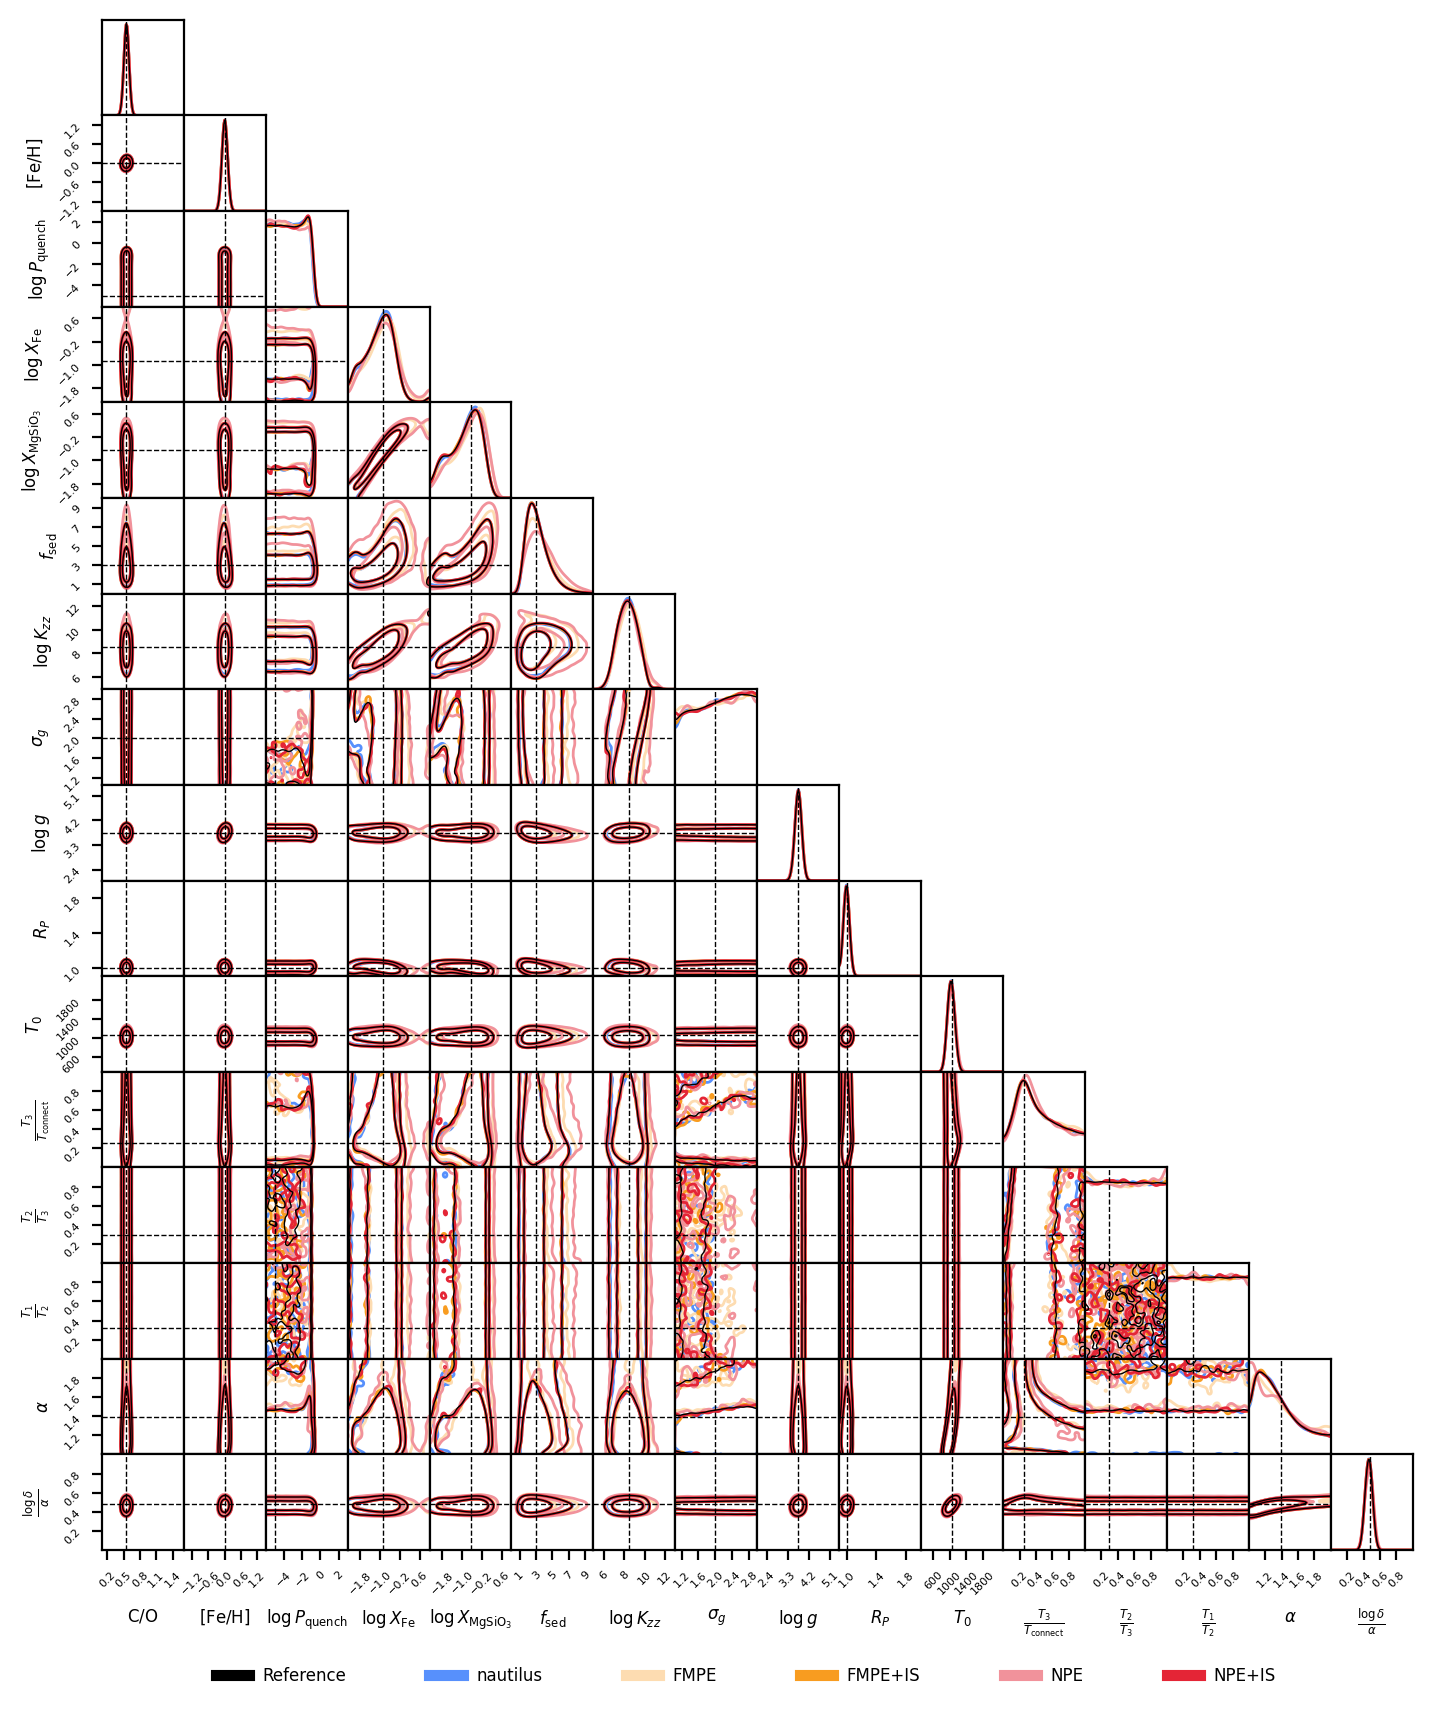

In [13]:
N = 16

pad_inches = 0.05
fig = plt.figure(figsize=(17.6 / 2.54 - 2 * pad_inches, 20.5 / 2.54 - 2 * pad_inches))
fig.tight_layout(pad=0)

# Plot posterior estimates
i = 0
for key, result in results.items():
    if key == "reference":
        continue
    fig = corner(
        fig=fig,
        data=result["samples"][:, :N],
        weights=result["weights"],
        color=COLORS[i],
        bins=100,
        range=[(lower, upper) for lower, upper in list(zip(LOWER, UPPER))[:N]],
        smooth=3,
        smooth1d=3,
        plot_datapoints=False,
        plot_contours=True,
        plot_density=False,
        # levels=(1 - np.exp(-0.5), 1 - np.exp(-1.0)),
        levels=(0.68, 0.95),
        contour_kwargs=dict(linewidths=1.0),
    )
    i += 1


# Plot the reference posterior
fig = corner(
    fig=fig,
    data=results["reference"]["samples"][:, :N],
    weights=results["reference"]["weights"],
    color="black",
    bins=100,
    range=[(lower, upper) for lower, upper in list(zip(LOWER, UPPER))[:N]],
    smooth=3,
    smooth1d=3,
    plot_datapoints=False,
    plot_contours=True,
    plot_density=False,
    # levels=(1 - np.exp(-0.5), 1 - np.exp(-1.0)),
    levels=(0.68, 0.95),
    contour_kwargs=dict(linewidths=0.5),
)


# Extract the axes
axes = np.array(fig.axes).reshape((N, N))


# Fix the histograms on the diagonal
for i, param in enumerate(NAMES[:N]):

    # Select ax and clear existing plot
    ax = axes[i, i]
    ax.clear()

    ax.set_yticks([])
    
    bins = np.linspace(LOWER[i], UPPER[i], N_BINS)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Plot all other methods
    j = 0
    for key, values in results.items():
        if key == "reference":
            continue
        c = COLORS[j]
        ax.plot(bin_centers, values["histograms"][param], label=values["label"], lw=1.0, c=c)
        j += 1

    # Plot the reference
    values = results["reference"]
    ax.plot(bin_centers, values["histograms"][param], label=values["label"], c="black", lw=0.5)


# Mark the true values
for row, col in product(range(N), range(N)):
    ax = axes[row, col]
    if col > row:
        continue
    elif col == row:
        ax.axvline(x=THETA_0[col], lw=0.5, ls="--", color="black")
    else:
        ax.axhline(y=THETA_0[row], lw=0.5, ls="--", color="black")
        ax.axvline(x=THETA_0[col], lw=0.5, ls="--", color="black")


# Fix the ax limits
for row, col in product(range(N), range(N)):
    
    ax = axes[row, col]
    if col > row:
        continue
    
    ax.set_xlim(LOWER[col], UPPER[col])
    if row == col:
        ax.set_ylim(0, None)
    else:
        ax.set_ylim(LOWER[row], UPPER[row])


# Remove ticks
for row, col in product(range(N), range(N)):
    ax = axes[row, col]
    if col > 0:
        ax.set_yticks([])
    if row < N - 1:
        ax.set_xticks([])


# Fix the labels
for row in range(1, N):
    axes[row, 0].set_ylabel(LABELS[row], fontsize=6)
for col in range(N):
    ax = axes[N - 1, col]
    # ax.set_xlabel(LABELS[col], fontsize=6)
    ax.set_xlabel("")
    ax.text(x=0.5, y=-0.6, s=LABELS[col], fontsize=6, va="top", ha="center", transform=ax.transAxes)


# Fix the fontsize of the ticks
for ax in axes.flatten():
    ax.tick_params(axis='x', labelsize=4, labelrotation=45)
    ax.tick_params(axis='y', labelsize=4)


# Add custom legend
handles = [
    Line2D([0], [0], color="black", lw=4),
    *[Line2D([0], [0], color=c, lw=4) for c in COLORS],
]
fig.legend(
    handles=handles, 
    labels=[result["label"] for result in results.values()],
    ncols=len(results),
    frameon=False,
    loc="lower center",
    fontsize=6,
    bbox_to_anchor=(0.5, -0.065),
    columnspacing=5,
)


# Fix the tick positions on the x-axis
for i, ticks in enumerate(
    [
        np.arange(0.2, 1.6, 0.3),
        np.arange(-1.2, 1.3, 0.6),
        np.arange(-4, 3, 2),
        np.arange(-1.8, 0.7, 0.8),
        np.arange(-1.8, 0.7, 0.8),
        np.arange(1, 10, 2),
        np.arange(6, 14, 2),
        np.arange(1.2, 3.0, 0.4),
        np.arange(2.4, 5.2, 0.9),
        np.arange(1, 1.9, 0.4),
        np.arange(600, 2100, 400),
        np.arange(0.2, 1.0, 0.2),
        np.arange(0.2, 1.0, 0.2),
        np.arange(0.2, 1.0, 0.2),
        np.arange(1.2, 2.0, 0.2),
        np.arange(0.2, 1.0, 0.2),
    ]
):
    if i > 0:
        axes[i, 0].set_yticks(ticks)
    axes[-1, i].set_xticks(ticks)


# Remove spaces and save as PDF
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("cornerplot.pdf", dpi=300, bbox_inches="tight", pad_inches=0.01)

plt.show()

# Create the corner plot (4 selected parameters)

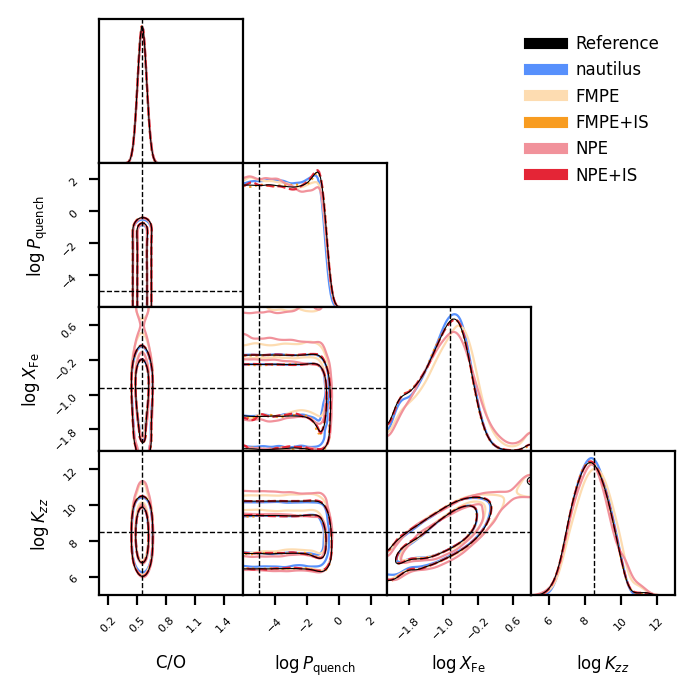

In [14]:
selection = np.array([0, 2, 3, 6])
N = len(selection)

pad_inches = 0.05
fig = plt.figure(figsize=(8.8 / 2.54 - 2 * pad_inches, 8.8 / 2.54 - 2 * pad_inches))
fig.tight_layout(pad=0)

# Plot posterior estimates
i = 0
for key, result in results.items():
    
    if key == "reference":
        continue

    ls = "-"
    if key == "npe_is":
        ls = "--"
    if key == "fmpe_is":
        ls = ":"
    
    fig = corner(
        fig=fig,
        data=result["samples"][:, selection],
        weights=result["weights"],
        color=COLORS[i],
        bins=100,
        range=[(LOWER[j], UPPER[j]) for j in selection],
        smooth=3,
        smooth1d=3,
        plot_datapoints=False,
        plot_contours=True,
        plot_density=False,
        levels=(0.68, 0.95),
        contour_kwargs=dict(linewidths=0.8, linestyles=ls),
    )
    i += 1

# Plot the reference posterior
fig = corner(
    fig=fig,
    data=results["reference"]["samples"][:, selection],
    weights=results["reference"]["weights"],
    color="black",
    bins=100,
    range=[(LOWER[j], UPPER[j]) for j in selection],
    smooth=3,
    smooth1d=3,
    plot_datapoints=False,
    plot_contours=True,
    plot_density=False,
    levels=(0.68, 0.95),
    contour_kwargs=dict(linewidths=0.4),
)


# Extract the axes
axes = np.array(fig.axes).reshape((N, N))


# Fix the histograms on the diagonal
for i, param in enumerate(np.array(NAMES)[selection]):

    # Select ax and clear existing plot
    ax = axes[i, i]
    ax.clear()

    ax.set_yticks([])
    
    bins = np.linspace(LOWER[selection[i]], UPPER[selection[i]], N_BINS)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Plot all other methods
    j = 0
    for key, values in results.items():
        
        if key == "reference":
            continue
    
        ls = "-"
        if key == "npe_is":
            ls = "--"
        if key == "fmpe_is":
            ls = ":"

        c = COLORS[j]
        ax.plot(bin_centers, values["histograms"][param], label=values["label"], lw=0.8, ls=ls, c=c)
        j += 1

    # Plot the reference
    values = results["reference"]
    ax.plot(bin_centers, values["histograms"][param], label=values["label"], c="black", lw=0.4)


# Mark the true values
for row, col in product(range(N), range(N)):
    ax = axes[row, col]
    if col > row:
        continue
    elif col == row:
        ax.axvline(x=THETA_0[selection[col]], lw=0.5, ls="--", color="black")
    else:
        ax.axhline(y=THETA_0[selection[row]], lw=0.5, ls="--", color="black")
        ax.axvline(x=THETA_0[selection[col]], lw=0.5, ls="--", color="black")


# Fix the ax limits
for row, col in product(range(N), range(N)):
    
    ax = axes[row, col]
    if col > row:
        continue
    
    ax.set_xlim(LOWER[selection[col]], UPPER[selection[col]])
    if row == col:
        ax.set_ylim(0, None)
    else:
        ax.set_ylim(LOWER[selection[row]], UPPER[selection[row]])


# Remove ticks
for row, col in product(range(N), range(N)):
    ax = axes[row, col]
    if col > 0:
        ax.set_yticks([])
    if row < N - 1:
        ax.set_xticks([])


# Fix the labels
for row in range(1, N):
    axes[row, 0].set_ylabel(LABELS[selection[row]], fontsize=6)
for col in range(N):
    ax = axes[N - 1, col]
    # ax.set_xlabel(LABELS[col], fontsize=6)
    ax.set_xlabel("")
    ax.text(x=0.5, y=-0.4, s=LABELS[selection[col]], fontsize=6, va="top", ha="center", transform=ax.transAxes)


# Fix the fontsize of the ticks
for ax in axes.flatten():
    ax.tick_params(axis='x', labelsize=4, labelrotation=45)
    ax.tick_params(axis='y', labelsize=4)


# Add custom legend
handles = [
    Line2D([0], [0], color="black", lw=4),
    *[Line2D([0], [0], color=c, lw=4) for c in COLORS],
]
axes[0, -1].legend(
    handles=handles, 
    labels=[result["label"] for result in results.values()],
    # ncols=len(results),
    frameon=False,
    loc="upper right",
    fontsize=6,
    # bbox_to_anchor=(0.5, -0.065),
    # columnspacing=5,
)


# Fix the tick positions on the x-axis
j = 0
for i, ticks in enumerate(
    [
        np.arange(0.2, 1.6, 0.3),
        np.arange(-1.2, 1.3, 0.6),
        np.arange(-4, 3, 2),
        np.arange(-1.8, 0.7, 0.8),
        np.arange(-1.8, 0.7, 0.8),
        np.arange(1, 10, 2),
        np.arange(6, 14, 2),
        np.arange(1.2, 3.0, 0.4),
        np.arange(2.4, 5.2, 0.9),
        np.arange(1, 1.9, 0.4),
        np.arange(600, 2100, 400),
        np.arange(0.2, 1.0, 0.2),
        np.arange(0.2, 1.0, 0.2),
        np.arange(0.2, 1.0, 0.2),
        np.arange(1.2, 2.0, 0.2),
        np.arange(0.2, 1.0, 0.2),
    ]
):
    if i not in selection:
        continue
    if j > 0:
        axes[j, 0].set_yticks(ticks)
    axes[-1, j].set_xticks(ticks)
    j += 1


# Remove spaces and save as PDF
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("subset.pdf", dpi=300, bbox_inches="tight", pad_inches=0.01)

plt.show()

# Plot only the marginals (smoothed histograms)

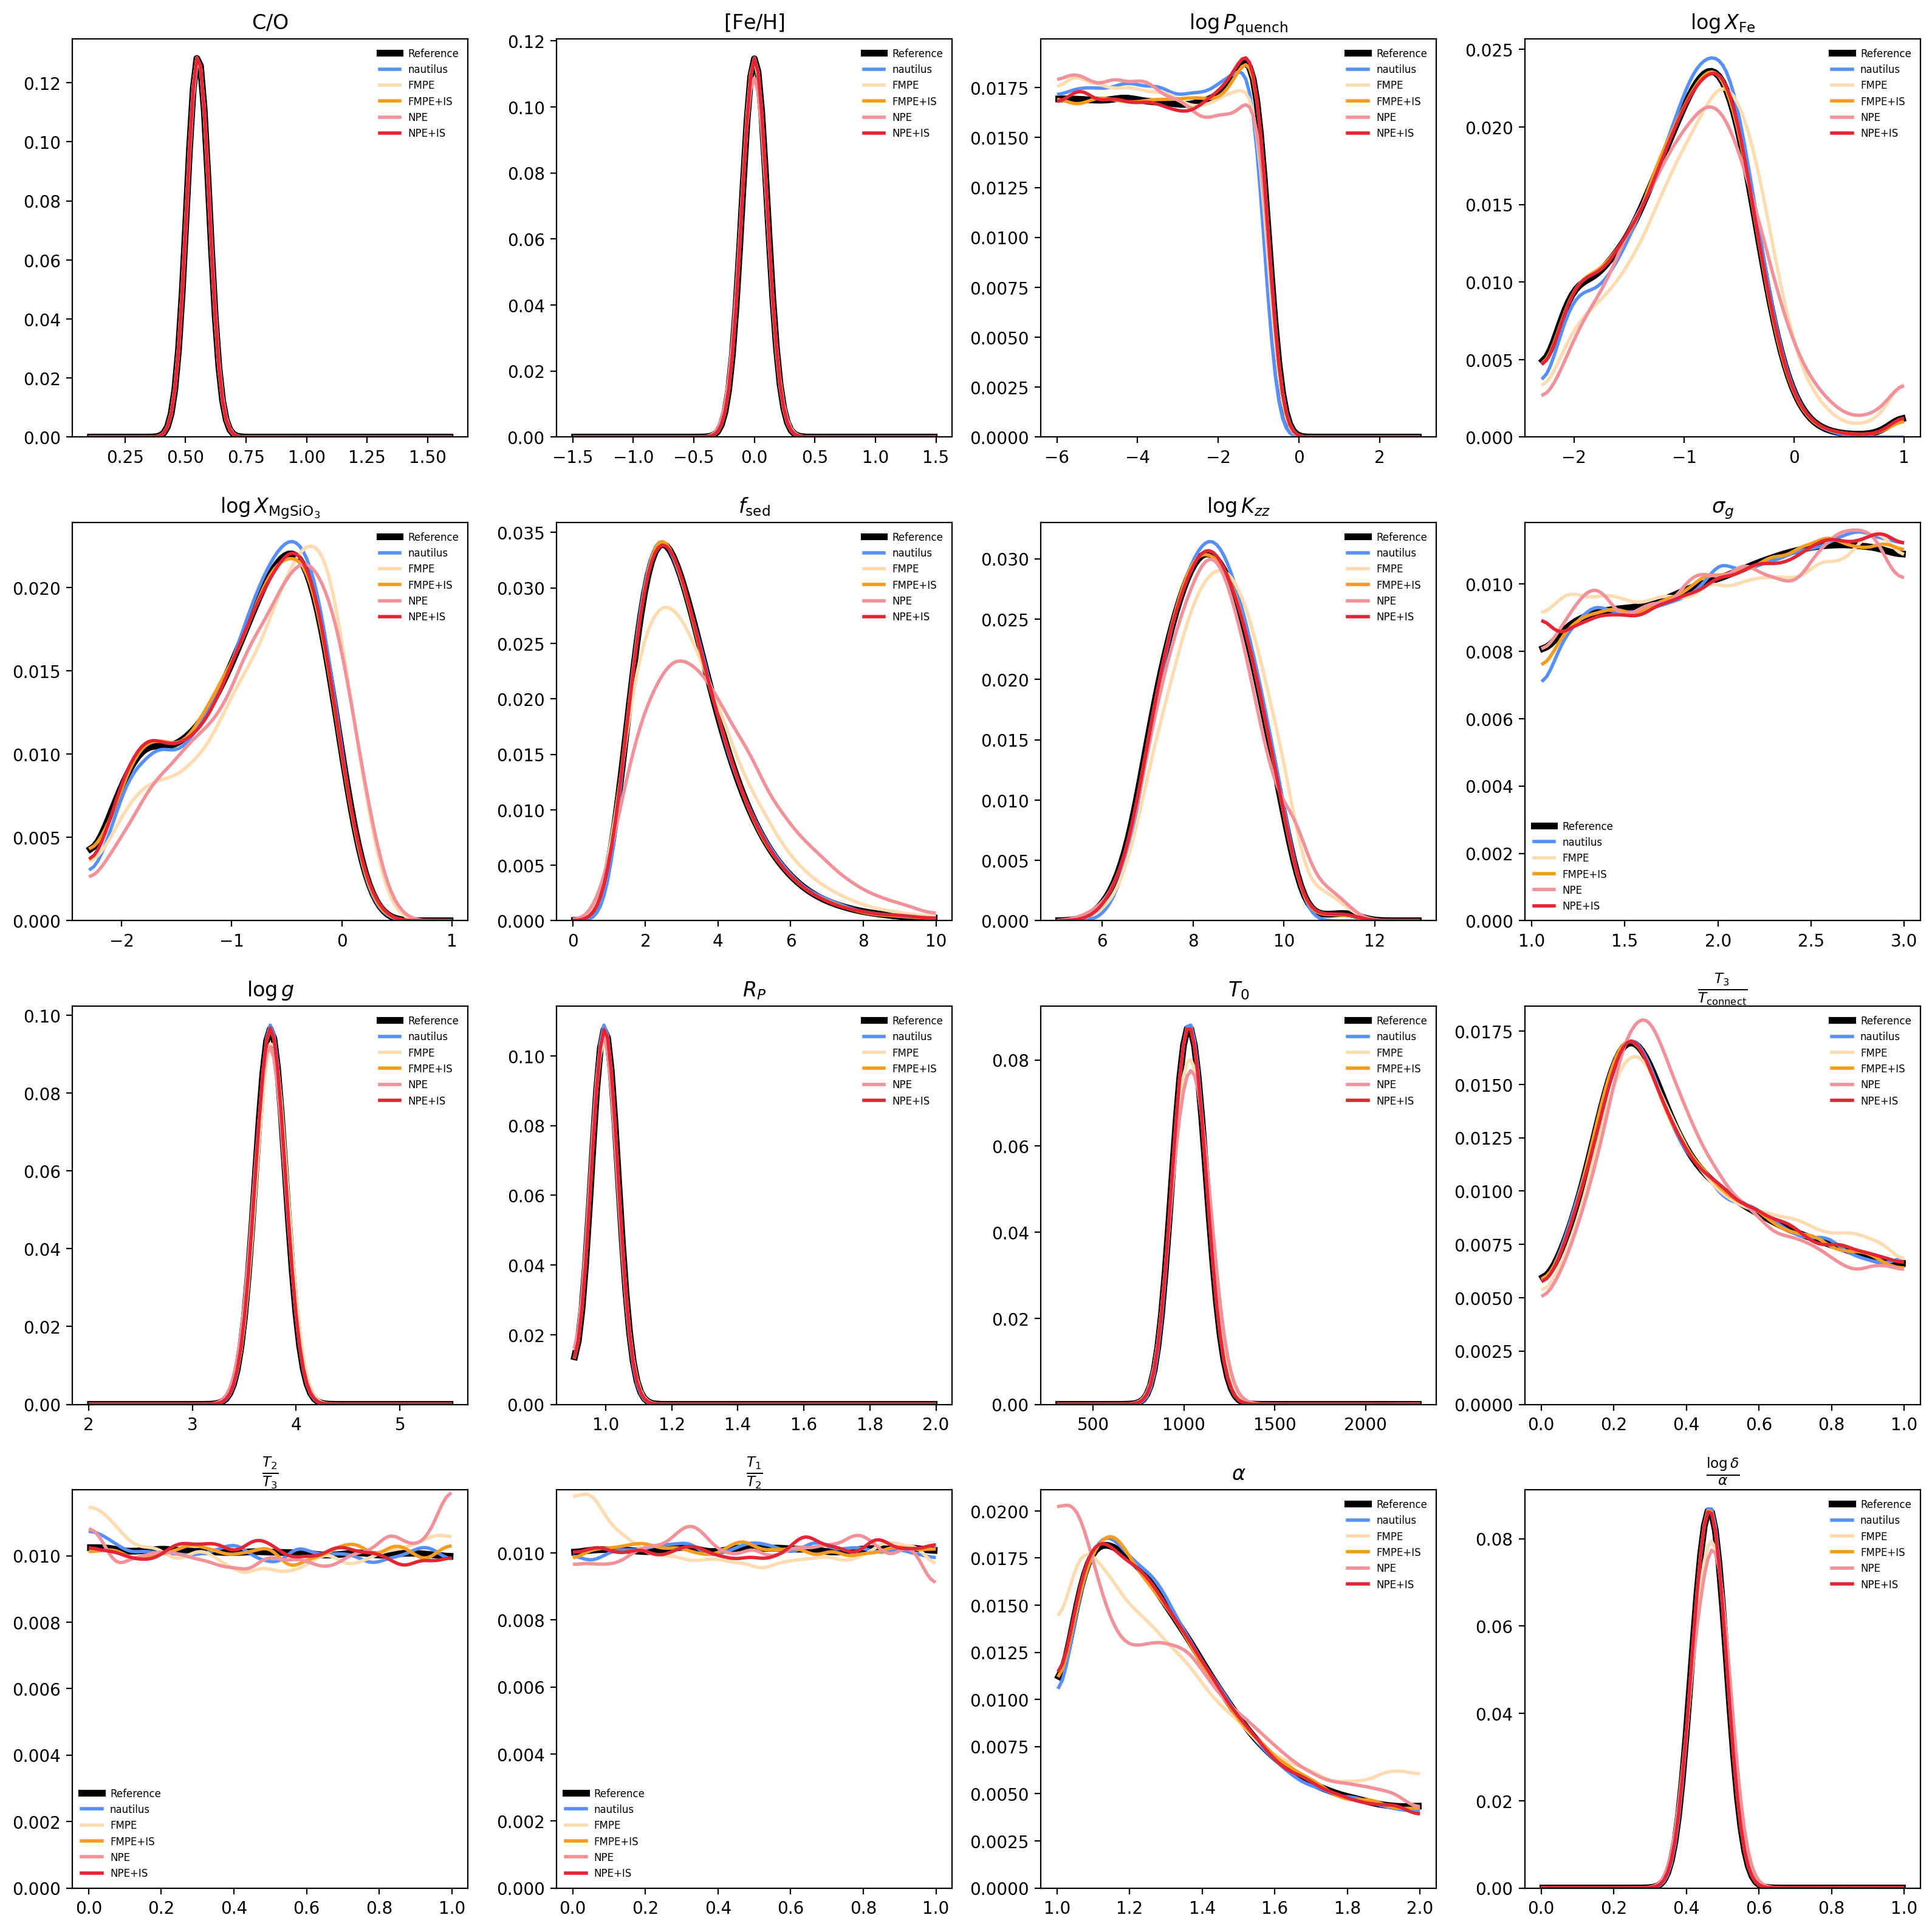

In [15]:
fig, axes = plt.subplots(figsize=(16, 16), ncols=4, nrows=4)
axes = np.array(axes).flatten()

for i, param in enumerate(NAMES):
    
    ax = axes[i]
    ax.set_title(LABELS[i])
    bins = np.linspace(LOWER[i], UPPER[i], N_BINS)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Plot the reference
    values = results["reference"]
    ax.plot(bin_centers, values["histograms"][param], label=values["label"], c="black", lw=4)

    # Plot all other methods
    j = 0
    for key, values in results.items():
        if key == "reference":
            continue
        c = COLORS[j]
        ax.plot(bin_centers, values["histograms"][param], label=values["label"], lw=2, c=c)
        j += 1
        
    ax.set_ylim(0, None)
    ax.legend(loc="best", fontsize=6, frameon=False)

fig.tight_layout()
plt.show()

# Compute Jensen-Shannon divergences w.r.t. reference

In [16]:
# Compute JSD for every method
for key in results.keys():

    # Prepare output dictionary
    results[key]["jsd"] = {}

    # Compute histograms for every atmospheric parameter
    for i, param in enumerate(NAMES):

        # Compute JSD in millinat (hence the factor of 1000)
        results[key]["jsd"][param] = 1000 * jensenshannon(
            results["reference"]["histograms"][param], 
            results[key]["histograms"][param], 
        )

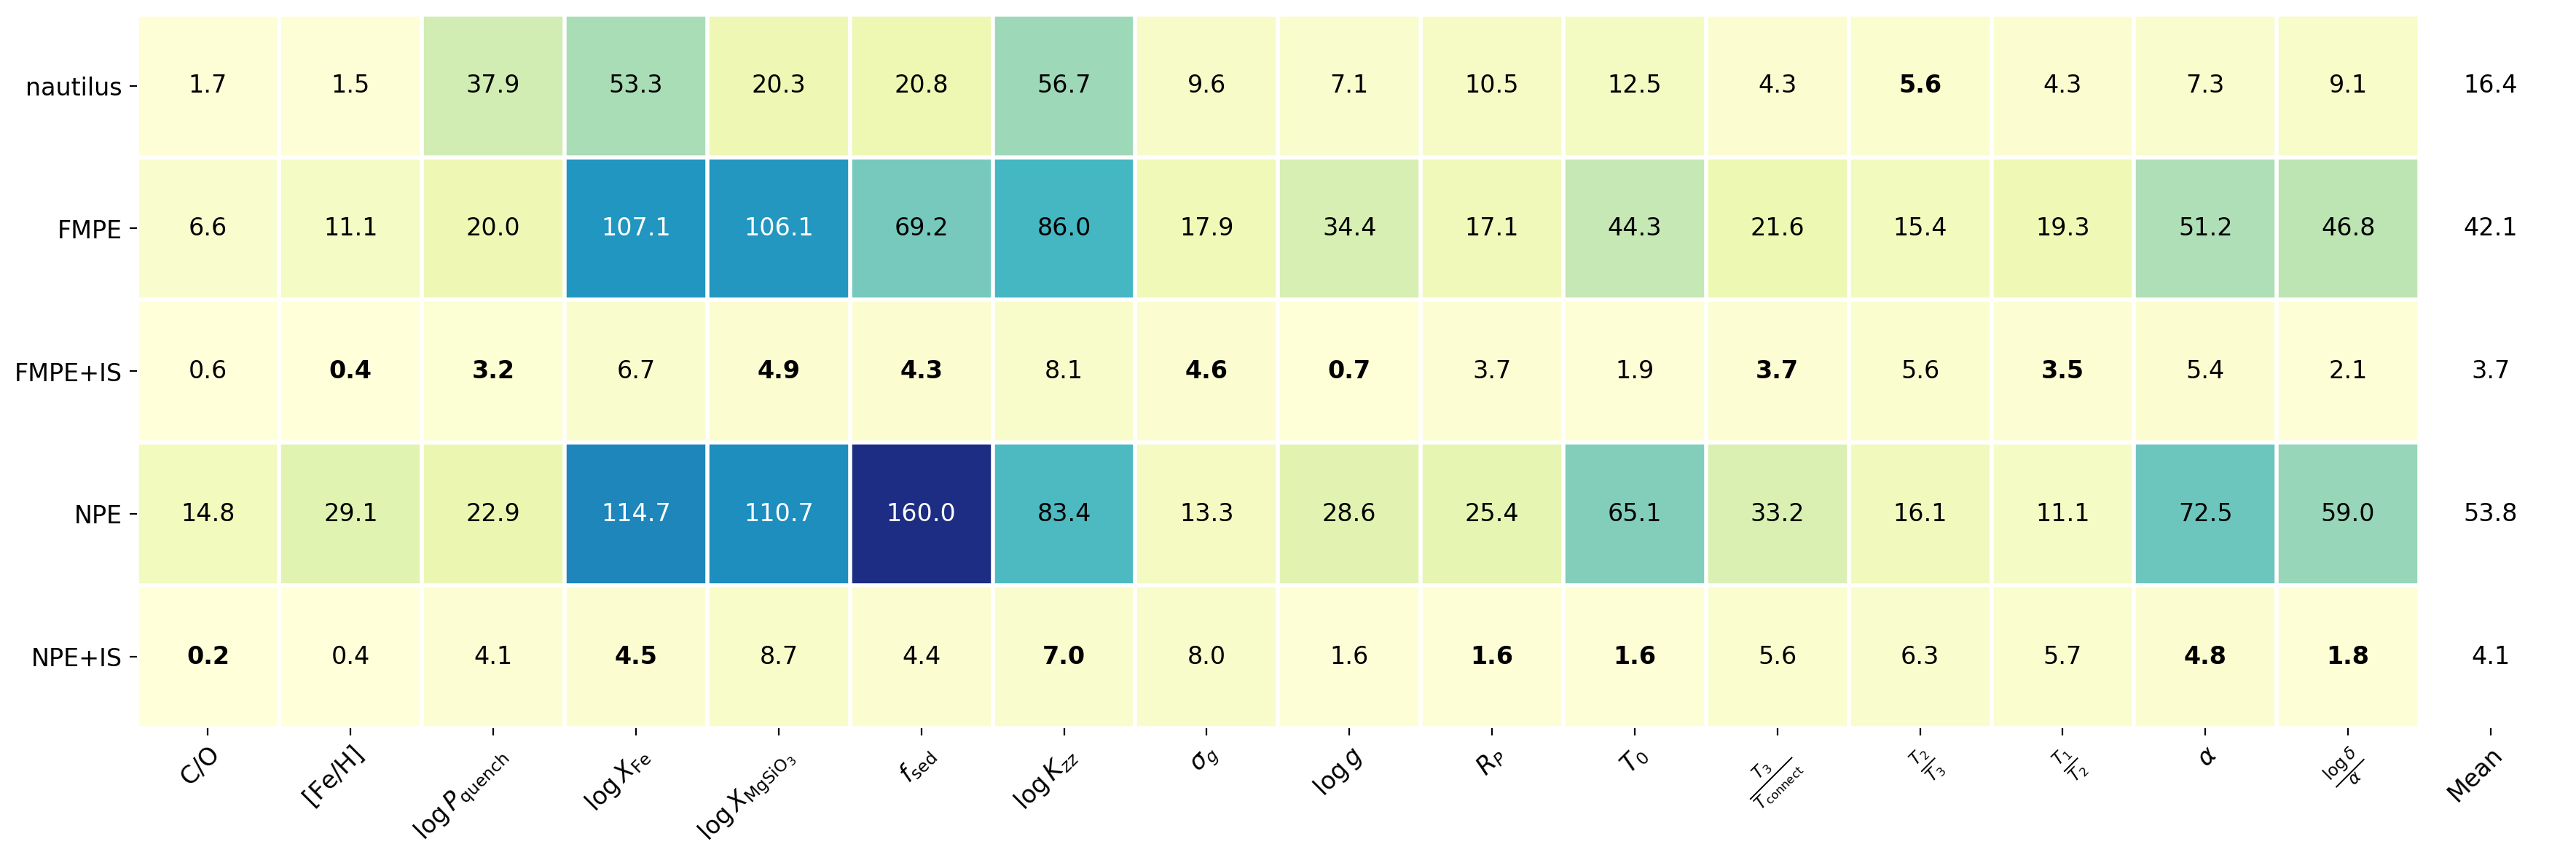

In [17]:
# Construct the matrix for the imshow plot
data = []
y_labels = []
for key in results.keys():
    if key == "reference":
        continue
    y_labels.append(results[key]["label"])
    row = [results[key]["jsd"][param] for param in NAMES]
    row.append(np.nan)  # Mean should not produce a color
    data.append(row)
data = np.array(data)

# Prepare the figure
fig, ax = plt.subplots(figsize=(17.78, 6.5))

# Create the plot
vmax = 1.1 * np.nanmax(data)
ax.imshow(data, vmin=0, vmax=vmax, cmap="YlGnBu")

# Add ticks ands labels
x_labels = list(LABELS) + ["Mean"]
ax.set_xticks(np.arange(data.shape[1]), labels=x_labels, fontsize=12)
ax.set_yticks(np.arange(data.shape[0]), labels=y_labels, fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Turn spines off and create white grid.
ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.tick_params(which="minor", bottom=False, left=False)

# Add text with the JSD value
for row, col in product(range(data.shape[0]), range(data.shape[1] - 1)):
    color = "white" if data[row, col] > vmax / 2 else "black"
    fontweight = "bold" if data[row, col] == np.min(data[:, col]) else "normal"
    ax.text(col, row, f"{data[row, col]:.1f}", ha="center", va="center", color=color, fontsize=12, fontweight=fontweight)

# Add the means
for row in range(data.shape[0]):
    row_mean = np.nanmean(data[row])
    ax.text(data.shape[1] - 1, row, f"{row_mean:.1f}", ha="center", va="center", fontsize=12)

fig.tight_layout()
# plt.savefig("/Users/timothy/Desktop/jsd-to-nested-sampling.png", dpi=600, bbox_inches="tight", pad_inches=0.01)
plt.show()

In [18]:
i = 0
for key in results.keys():
    
    if key == "reference":
        continue
    
    print(results[key]["label"], end="")

    for j in range(data.shape[1] - 1):
        if data[i, j] == np.min(data[:, j]):
            print(f" & \\textbf{{\cc{{{data[i, j]:.1f}}}}} ", end="")
        else:
            print(f" & \cc{{{data[i, j]:.1f}}}", end="")

    print(f" & \cc{{{np.nanmean(data[i, :]):.1f}}}") 
    print("\\\\")
    print("\\noalign{\color{white}\hrule height 2.5pt}%")
    i += 1

nautilus & \cc{1.7} & \cc{1.5} & \cc{37.9} & \cc{53.3} & \cc{20.3} & \cc{20.8} & \cc{56.7} & \cc{9.6} & \cc{7.1} & \cc{10.5} & \cc{12.5} & \cc{4.3} & \textbf{\cc{5.6}}  & \cc{4.3} & \cc{7.3} & \cc{9.1} & \cc{16.4}
\\
\noalign{\color{white}\hrule height 2.5pt}%
FMPE & \cc{6.6} & \cc{11.1} & \cc{20.0} & \cc{107.1} & \cc{106.1} & \cc{69.2} & \cc{86.0} & \cc{17.9} & \cc{34.4} & \cc{17.1} & \cc{44.3} & \cc{21.6} & \cc{15.4} & \cc{19.3} & \cc{51.2} & \cc{46.8} & \cc{42.1}
\\
\noalign{\color{white}\hrule height 2.5pt}%
FMPE+IS & \cc{0.6} & \textbf{\cc{0.4}}  & \textbf{\cc{3.2}}  & \cc{6.7} & \textbf{\cc{4.9}}  & \textbf{\cc{4.3}}  & \cc{8.1} & \textbf{\cc{4.6}}  & \textbf{\cc{0.7}}  & \cc{3.7} & \cc{1.9} & \textbf{\cc{3.7}}  & \cc{5.6} & \textbf{\cc{3.5}}  & \cc{5.4} & \cc{2.1} & \cc{3.7}
\\
\noalign{\color{white}\hrule height 2.5pt}%
NPE & \cc{14.8} & \cc{29.1} & \cc{22.9} & \cc{114.7} & \cc{110.7} & \cc{160.0} & \cc{83.4} & \cc{13.3} & \cc{28.6} & \cc{25.4} & \cc{65.1} & \cc{33.2} & \cc{16.